# Dec 1st, 2021 (consistency across sessions)

**Motivation**: How to choose hyperparameters in a principled way <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Portrait Divergence

### on synthetic graphs

In [2]:
sys.path.insert(0, pjoin(git_dir, 'network-portrait-divergence'))
from portrait_divergence import portrait_divergence, portrait_py, portrait_cpp

In [3]:
Ger1  = nx.erdos_renyi_graph(100, 3/99)
Ger2  = nx.erdos_renyi_graph(100, 3/99)
Gba1 = nx.barabasi_albert_graph(100, 3)
Gba2 = nx.barabasi_albert_graph(100, 3)

print("Djs(ER1,ER2) =", portrait_divergence(Ger1, Ger2))
print("Djs(ER1,BA1) =", portrait_divergence(Ger1, Gba1))
print("Djs(ER1,BA2) =", portrait_divergence(Ger1, Gba2))
print("Djs(BA1,BA2) =", portrait_divergence(Gba1, Gba2))

Djs(ER1,ER2) = 0.14416570226636283

Djs(ER1,BA1) = 0.8544827567126247

Djs(ER1,BA2) = 0.8164185636183563

Djs(BA1,BA2) = 0.18941045187651834

In [10]:
%timeit B = portrait_cpp(Ger1)

927 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit B = portrait_py(Ger1)

2.2 s ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


18.6 ms ± 610 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


34.9 ms ± 505 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### On real graphs (ca2)

In [16]:
mice = Mice((192, 4))
mice.setup_func_data('rest')

In [17]:
adjacencies = collections.defaultdict(list)
for key in mice.ca:
    sub, ses, run = mice.looper[key]
    if run == -1:
        continue
    net = Network(mice, key, 'ca2').load_network()
    adjacencies[ses].append(np.expand_dims(net.adj, 0))

adjacencies = {
    k: np.concatenate(v) for
    k, v in adjacencies.items()
}

n_runs = 0
ses_ids = {}
for ses, a in adjacencies.items():
    ses_ids[ses] = range(n_runs, n_runs + len(a))
    n_runs += len(a)
    
adjacencies = np.concatenate(list(adjacencies.values()))
assert len(adjacencies) == n_runs

n_runs, ses_ids, adjacencies.shape

(114, {1: range(0, 39), 2: range(39, 78), 3: range(78, 114)}, (114, 300, 300))

In [18]:
start = 0.60
stop = 0.01
num = 100
densities = np.logspace(np.log10(start), np.log10(stop), num)
densities

array([0.6       , 0.57569191, 0.55236863, 0.52999025, 0.5085185 ,
       0.48791664, 0.46814944, 0.44918308, 0.4309851 , 0.4135244 ,
       0.39677108, 0.3806965 , 0.36527316, 0.35047468, 0.33627573,
       0.32265202, 0.30958027, 0.29703809, 0.28500404, 0.27345754,
       0.26237882, 0.25174894, 0.24154971, 0.23176369, 0.22237414,
       0.21336499, 0.20472083, 0.19642688, 0.18846894, 0.18083341,
       0.17350721, 0.16647783, 0.15973324, 0.15326189, 0.14705271,
       0.1410951 , 0.13537884, 0.12989417, 0.12463171, 0.11958244,
       0.11473774, 0.11008932, 0.10562922, 0.10134981, 0.09724377,
       0.09330409, 0.08952402, 0.08589709, 0.0824171 , 0.07907809,
       0.07587436, 0.07280043, 0.06985103, 0.06702112, 0.06430586,
       0.06170061, 0.0592009 , 0.05680247, 0.0545012 , 0.05229317,
       0.05017459, 0.04814184, 0.04619145, 0.04432007, 0.04252451,
       0.0408017 , 0.03914868, 0.03756263, 0.03604083, 0.03458069,
       0.03317971, 0.03183548, 0.03054572, 0.0293082 , 0.02812083,
       0.02698155, 0.02588844, 0.02483961, 0.02383327, 0.0228677 ,
       0.02194125, 0.02105233, 0.02019943, 0.01938108, 0.01859589,
       0.0178425 , 0.01711964, 0.01642606, 0.01576059, 0.01512207,
       0.01450942, 0.01392159, 0.01335758, 0.01281642, 0.01229718,
       0.01179898, 0.01132096, 0.01086231, 0.01042224, 0.01      ])

In [19]:
%%time

graphs = collections.defaultdict(list)
portraits = collections.defaultdict(list)
thresholds = np.zeros((n_runs, len(densities)))

for ses, ids in ses_ids.items():
    for i in tqdm(ids, leave=False):
        a = adjacencies[i]
        thres = calculate_threshold(a, densities)
        thresholds[i] = thres
        
        nonzero = np.abs(a).mean(0) > 0
        for d, th in tqdm(zip(densities, thres), leave=False):
            a_eff = a[nonzero][:, nonzero]
            a_eff[a_eff <= th] = 0.
            g = nx.from_numpy_matrix(a_eff)
            graphs[i].append(g)
            portraits[i].append(portrait_cpp(g))

  0%|          | 0/39 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 7min 40s, sys: 26.3 s, total: 8min 7s
Wall time: 20min 41s


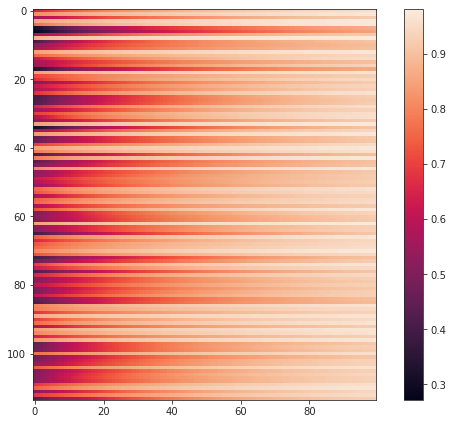

In [20]:
fig, ax = create_figure(figsize=(8, 6))
im = ax.imshow(thresholds, aspect=1)
plt.colorbar(im, ax=ax)
plt.show()

<matplotlib.image.AxesImage object at 0x7ff1a2e5bc10>

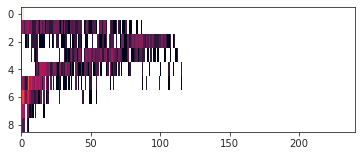

In [23]:
plt.imshow(np.log(portraits[16][40]), aspect=10)

In [24]:
div = np_nans((len(densities), n_runs, n_runs))
for di in tqdm(range(len(densities))):
    for i, j in tqdm(itertools.combinations(range(n_runs), 2), leave=False):
        div[di, i, j] = portrait_divergence(portraits[i][di], portraits[j][di])

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [26]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = []
    for v in across.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
    
    data = []
    for v in within.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
df1 = pd.DataFrame(merge_dicts(dlist))

In [27]:
len(df1)

644100

In [28]:
df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.07907809290541412, 0.3112823145590308)

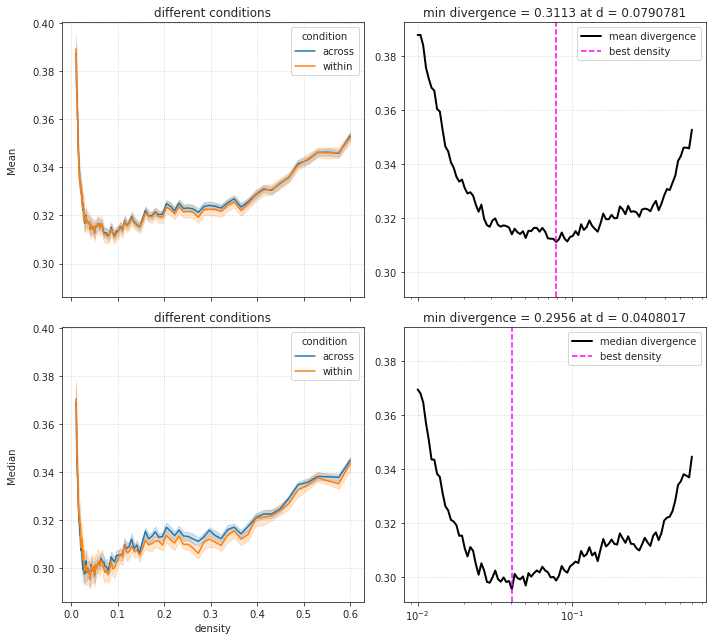

In [30]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df1.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [32]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = {k: v.mean() for k, v in across.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
    
    data = {k: v.mean() for k, v in within.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
df2 = pd.DataFrame(merge_dicts(dlist))

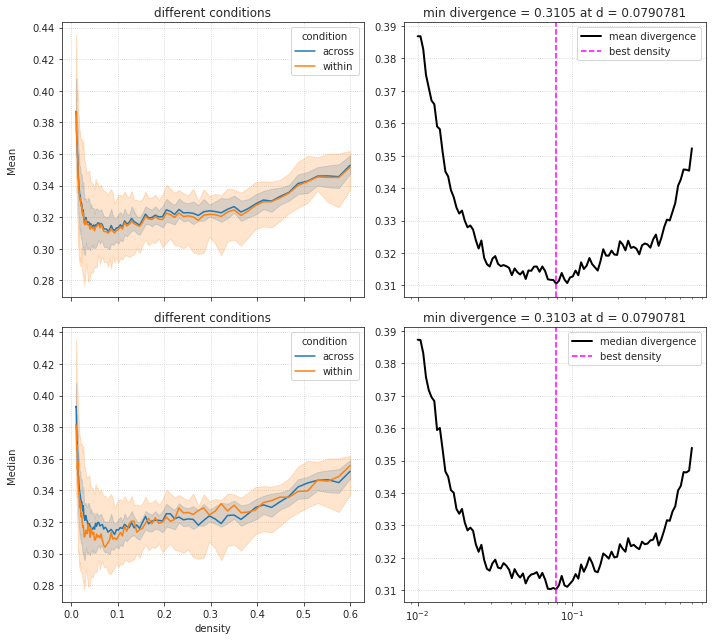

In [33]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df2.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [35]:
# df_avg = df.loc[df['condition'] == 'within'].groupby(['density']).median()
df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.07907809290541412, 0.3103042382283482)

### tSNE on distance matrix

In [38]:
best_di = np.where(densities == best_d)[0].item()
best_di, densities[best_di]

(49, 0.07907809290541412)

<matplotlib.colorbar.Colorbar object at 0x7ff1a10a2910>

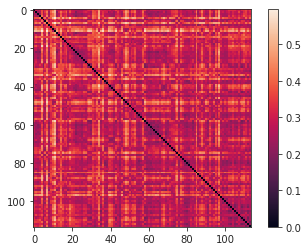

In [39]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

plt.imshow(x)
plt.colorbar()

In [40]:
from sklearn.manifold import TSNE, MDS

In [41]:
mds = MDS(n_components=2, dissimilarity='precomputed')
x_emb = mds.fit_transform(x)

In [42]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = [1] * len(ses_ids[1]) + [2] * len(ses_ids[2]) + [3] * len(ses_ids[3])

<AxesSubplot:xlabel='x', ylabel='y'>

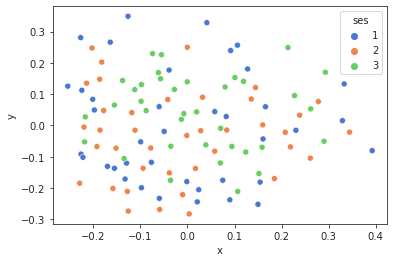

In [43]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')

In [47]:
x_emb = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)

In [48]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = [1] * len(ses_ids[1]) + [2] * len(ses_ids[2]) + [3] * len(ses_ids[3])

<AxesSubplot:xlabel='x', ylabel='y'>

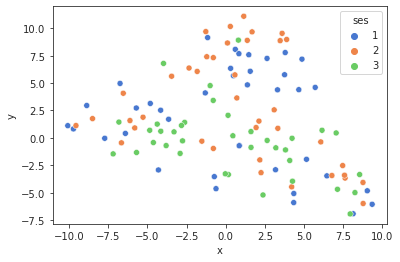

In [49]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')

### On real graphs (bold-lite)

In [50]:
mice = Mice((192, 4))
mice.setup_func_data('rest')

In [51]:
adjacencies = collections.defaultdict(list)
for key in mice.bold:
    sub, ses, run = mice.looper[key]
    if run == -1:
        continue
    net = Network(mice, key, 'bold-lite').load_network()
    adjacencies[ses].append(np.expand_dims(net.adj, 0))

adjacencies = {
    k: np.concatenate(v) for
    k, v in adjacencies.items()
}

n_runs = 0
ses_ids = {}
for ses, a in adjacencies.items():
    ses_ids[ses] = range(n_runs, n_runs + len(a))
    n_runs += len(a)
    
adjacencies = np.concatenate(list(adjacencies.values()))
assert len(adjacencies) == n_runs

n_runs, ses_ids, adjacencies.shape

(110, {1: range(0, 36), 2: range(36, 74), 3: range(74, 110)}, (110, 300, 300))

In [52]:
start = 0.60
stop = 0.01
num = 100
densities = np.logspace(np.log10(start), np.log10(stop), num)
densities

array([0.6       , 0.57569191, 0.55236863, 0.52999025, 0.5085185 ,
       0.48791664, 0.46814944, 0.44918308, 0.4309851 , 0.4135244 ,
       0.39677108, 0.3806965 , 0.36527316, 0.35047468, 0.33627573,
       0.32265202, 0.30958027, 0.29703809, 0.28500404, 0.27345754,
       0.26237882, 0.25174894, 0.24154971, 0.23176369, 0.22237414,
       0.21336499, 0.20472083, 0.19642688, 0.18846894, 0.18083341,
       0.17350721, 0.16647783, 0.15973324, 0.15326189, 0.14705271,
       0.1410951 , 0.13537884, 0.12989417, 0.12463171, 0.11958244,
       0.11473774, 0.11008932, 0.10562922, 0.10134981, 0.09724377,
       0.09330409, 0.08952402, 0.08589709, 0.0824171 , 0.07907809,
       0.07587436, 0.07280043, 0.06985103, 0.06702112, 0.06430586,
       0.06170061, 0.0592009 , 0.05680247, 0.0545012 , 0.05229317,
       0.05017459, 0.04814184, 0.04619145, 0.04432007, 0.04252451,
       0.0408017 , 0.03914868, 0.03756263, 0.03604083, 0.03458069,
       0.03317971, 0.03183548, 0.03054572, 0.0293082 , 0.02812083,
       0.02698155, 0.02588844, 0.02483961, 0.02383327, 0.0228677 ,
       0.02194125, 0.02105233, 0.02019943, 0.01938108, 0.01859589,
       0.0178425 , 0.01711964, 0.01642606, 0.01576059, 0.01512207,
       0.01450942, 0.01392159, 0.01335758, 0.01281642, 0.01229718,
       0.01179898, 0.01132096, 0.01086231, 0.01042224, 0.01      ])

In [53]:
%%time

graphs = collections.defaultdict(list)
portraits = collections.defaultdict(list)
thresholds = np.zeros((n_runs, len(densities)))

for ses, ids in ses_ids.items():
    for i in tqdm(ids, leave=False):
        a = adjacencies[i]
        thres = calculate_threshold(a, densities)
        thresholds[i] = thres
        
        nonzero = np.abs(a).mean(0) > 0
        for d, th in tqdm(zip(densities, thres), leave=False):
            a_eff = a[nonzero][:, nonzero]
            a_eff[a_eff <= th] = 0.
            g = nx.from_numpy_matrix(a_eff)
            graphs[i].append(g)
            portraits[i].append(portrait_cpp(g))

  0%|          | 0/36 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 10min 48s, sys: 43.6 s, total: 11min 32s
Wall time: 32min 13s


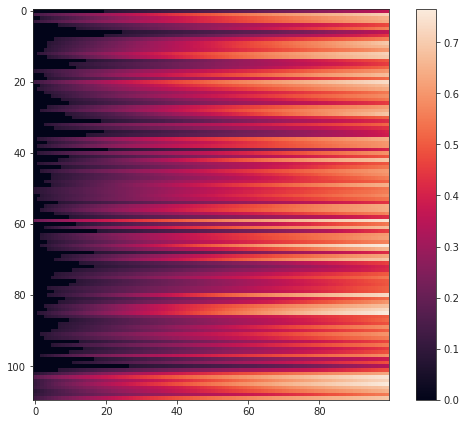

In [54]:
fig, ax = create_figure(figsize=(8, 6))
im = ax.imshow(thresholds, aspect=1)
plt.colorbar(im, ax=ax)
plt.show()

<matplotlib.image.AxesImage object at 0x7ff7d0a3cf10>

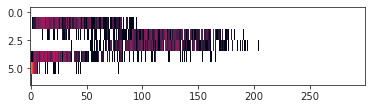

In [55]:
plt.imshow(np.log(portraits[16][40]), aspect=10)

In [56]:
div = np_nans((len(densities), n_runs, n_runs))
for di in tqdm(range(len(densities))):
    for i, j in tqdm(itertools.combinations(range(n_runs), 2), leave=False):
        div[di, i, j] = portrait_divergence(portraits[i][di], portraits[j][di])

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [57]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = []
    for v in across.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
    
    data = []
    for v in within.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
df1 = pd.DataFrame(merge_dicts(dlist))

In [58]:
len(df1)

599500

In [59]:
df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.35047467504718555, 0.343424728845633)

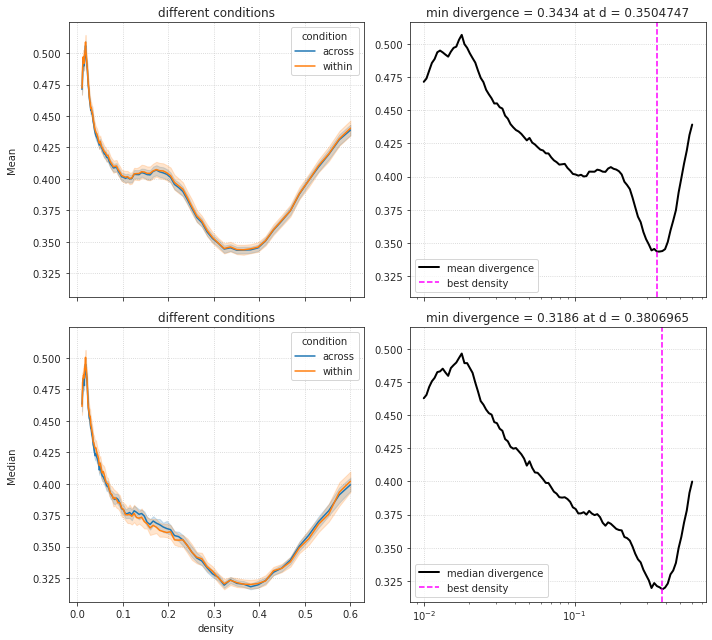

In [60]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df1.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [61]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = {k: v.mean() for k, v in across.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
    
    data = {k: v.mean() for k, v in within.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
df2 = pd.DataFrame(merge_dicts(dlist))

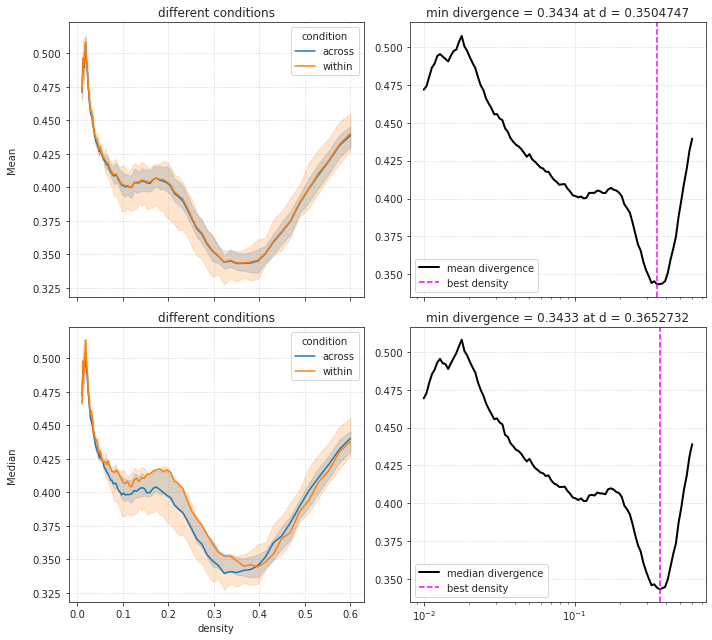

In [62]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df2.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [76]:
# df_avg = df2.loc[df2['condition'] == 'within'].groupby(['density']).median()
df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.35047467504718555, 0.343424728845633)

### tSNE on distance matrix

In [77]:
best_di = np.where(densities == best_d)[0].item()
best_di, densities[best_di]

(13, 0.35047467504718555)

<matplotlib.colorbar.Colorbar object at 0x7ff1a20458b0>

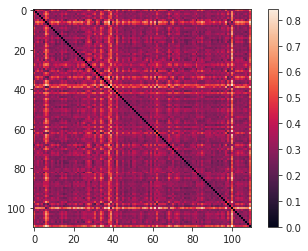

In [78]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

plt.imshow(x)
plt.colorbar()

In [79]:
from sklearn.manifold import TSNE, MDS

In [80]:
mds = MDS(n_components=2, dissimilarity='precomputed')
x_emb = mds.fit_transform(x)

In [81]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = [1] * len(ses_ids[1]) + [2] * len(ses_ids[2]) + [3] * len(ses_ids[3])

<AxesSubplot:xlabel='x', ylabel='y'>

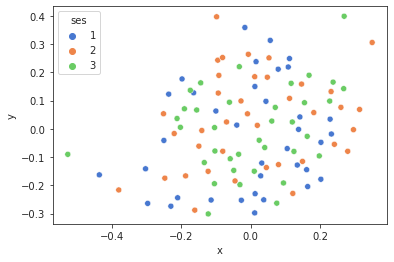

In [82]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')

In [83]:
x_emb = TSNE(
    n_components=2,
    perplexity=30,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)

In [84]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = [1] * len(ses_ids[1]) + [2] * len(ses_ids[2]) + [3] * len(ses_ids[3])

<AxesSubplot:xlabel='x', ylabel='y'>

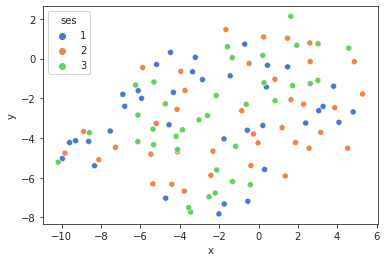

In [85]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')

### On real graphs (bold-lite)

In [3]:
mice = Mice((192, 4))
mice.setup_func_data('rest')

In [4]:
adjacencies = collections.defaultdict(list)
for key in tqdm(mice.bold):
    sub, ses, run = mice.looper[key]
    if run == -1:
        continue
    net = Network(mice, key, 'bold').load_network()
    adjacencies[ses].append(np.expand_dims(net.adj, 0))

adjacencies = {
    k: np.concatenate(v) for
    k, v in adjacencies.items()
}

n_runs = 0
ses_ids = {}
for ses, a in adjacencies.items():
    ses_ids[ses] = range(n_runs, n_runs + len(a))
    n_runs += len(a)
    
adjacencies = np.concatenate(list(adjacencies.values()))
assert len(adjacencies) == n_runs

n_runs, ses_ids, adjacencies.shape

  0%|          | 0/153 [00:00<?, ?it/s]

(110, {1: range(0, 36), 2: range(36, 74), 3: range(74, 110)}, (110, 1742, 1742))

In [7]:
start = 0.60
stop = 0.01
num = 50
densities = np.logspace(np.log10(start), np.log10(stop), num)
densities

array([0.6       , 0.55190261, 0.50766082, 0.46696556, 0.42953252,
       0.3951002 , 0.36342805, 0.33429482, 0.30749697, 0.2828473 ,
       0.26017361, 0.23931749, 0.22013325, 0.20248686, 0.18625504,
       0.17132441, 0.15759065, 0.14495781, 0.13333766, 0.12264901,
       0.11281718, 0.10377349, 0.09545477, 0.08780289, 0.08076441,
       0.07429015, 0.06833488, 0.062857  , 0.05781823, 0.05318339,
       0.04892009, 0.04499854, 0.04139135, 0.03807333, 0.03502128,
       0.03221389, 0.02963155, 0.02725622, 0.0250713 , 0.02306152,
       0.02121286, 0.01951239, 0.01794823, 0.01650946, 0.01518602,
       0.01396867, 0.01284891, 0.01181891, 0.01087148, 0.01      ])

In [ ]:
%%time

graphs = collections.defaultdict(list)
portraits = collections.defaultdict(list)
thresholds = np.zeros((n_runs, len(densities)))

for ses, ids in ses_ids.items():
    for i in tqdm(ids, leave=False):
        a = adjacencies[i]
        thres = calculate_threshold(a, densities)
        thresholds[i] = thres
        
        nonzero = np.abs(a).mean(0) > 0
        for d, th in tqdm(zip(densities, thres), leave=False):
            a_eff = a[nonzero][:, nonzero]
            a_eff[a_eff <= th] = 0.
            g = nx.from_numpy_matrix(a_eff)
            graphs[i].append(g)
            portraits[i].append(portrait_cpp(g))

  0%|          | 0/36 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
save_obj(portraits, f"portraits_bold_{now()}", tmp_dir, 'npy')

In [ ]:
fig, ax = create_figure(figsize=(8, 6))
im = ax.imshow(thresholds, aspect=1)
plt.colorbar(im, ax=ax)
plt.show()

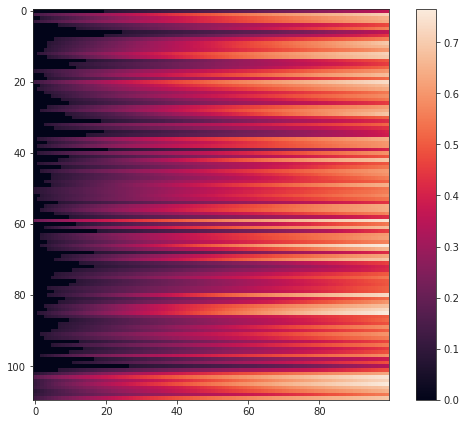

In [ ]:
plt.imshow(np.log(portraits[16][40]), aspect=10)

In [ ]:
div = np_nans((len(densities), n_runs, n_runs))
for di in tqdm(range(len(densities))):
    for i, j in tqdm(itertools.combinations(range(n_runs), 2), leave=False):
        div[di, i, j] = portrait_divergence(portraits[i][di], portraits[j][di])

In [ ]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = []
    for v in across.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
    
    data = []
    for v in within.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
df1 = pd.DataFrame(merge_dicts(dlist))

In [ ]:
len(df1)

In [ ]:
df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

In [ ]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df1.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [ ]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = {k: v.mean() for k, v in across.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
    
    data = {k: v.mean() for k, v in within.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
df2 = pd.DataFrame(merge_dicts(dlist))

In [ ]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df2.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [ ]:
# df_avg = df2.loc[df2['condition'] == 'within'].groupby(['density']).median()
df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

### tSNE on distance matrix

In [ ]:
best_di = np.where(densities == best_d)[0].item()
best_di, densities[best_di]

In [ ]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

plt.imshow(x)
plt.colorbar()

In [ ]:
from sklearn.manifold import TSNE, MDS

In [ ]:
mds = MDS(n_components=2, dissimilarity='precomputed')
x_emb = mds.fit_transform(x)

In [ ]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = [1] * len(ses_ids[1]) + [2] * len(ses_ids[2]) + [3] * len(ses_ids[3])

In [ ]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')

In [ ]:
x_emb = TSNE(
    n_components=2,
    perplexity=30,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)

In [ ]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = [1] * len(ses_ids[1]) + [2] * len(ses_ids[2]) + [3] * len(ses_ids[3])

In [ ]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')

## Fixed threshold

In [166]:
np.min(thresholds), np.max(thresholds), 

(0.3406013552578021, 0.9811199185752295)

In [168]:
start = 0.98
stop = 0.40
spacing = 0.01
num = int(np.ceil((start - stop) / spacing)) + 1
fixed_thresholds = np.linspace(start, stop, num)
fixed_thresholds = np.round(fixed_thresholds, 4)
fixed_thresholds

array([0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9 , 0.89, 0.88,
       0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 , 0.79, 0.78, 0.77,
       0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69, 0.68, 0.67, 0.66,
       0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58, 0.57, 0.56, 0.55,
       0.54, 0.53, 0.52, 0.51, 0.5 , 0.49, 0.48, 0.47, 0.46, 0.45, 0.44,
       0.43, 0.42, 0.41, 0.4 ])

In [184]:
len(fixed_thresholds), len(thresholds)

(59, 114)

In [173]:
%%time

graphs = collections.defaultdict(dict)
portraits = collections.defaultdict(dict)
densities = np.zeros((n_runs, len(fixed_thresholds)))

for ses, ids in ses_ids.items():
    for i in tqdm(ids, leave=False):
        a = adjacencies[i]
        nonzero = np.abs(a).mean(0) > 0
        for j, th in enumerate(fixed_thresholds):
            a_eff = a[nonzero][:, nonzero]
            a_eff[a_eff <= th] = 0
            a_eff[a_eff > th] = 1
            g = nx.from_numpy_matrix(a_eff)
            graphs[i][np.round(th, 4)] = g
            portraits[i][np.round(th, 4)] = portrait_py(g)
            densities[i, j] = nx.density(g)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 36min 29s, sys: 20.7 s, total: 36min 50s
Wall time: 36min 49s


<matplotlib.colorbar.Colorbar object at 0x7f44cf58c310>

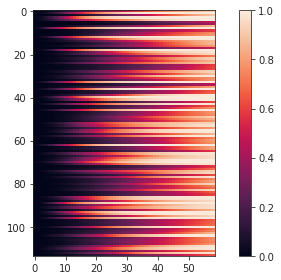

In [185]:
fig, ax = create_figure(figsize=(7, 4))
im = ax.imshow(densities[:, :len(fixed_thresholds)], aspect=0.7)
plt.colorbar(im, ax=ax)

<matplotlib.image.AxesImage object at 0x7f3f0451bee0>

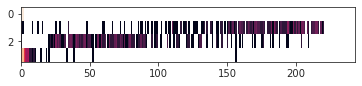

In [266]:
plt.imshow(np.log(portraits[16][0.5]), aspect=10)

<matplotlib.image.AxesImage object at 0x7f3f044b0b20>

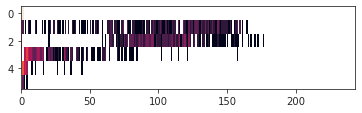

In [268]:
plt.imshow(np.log(portraits[17][0.5]), aspect=10)

In [277]:
div = np.zeros((len(fixed_thresholds), n_runs, n_runs))
div.shape

(59, 114, 114)

In [278]:
for th_i, th in tqdm(enumerate(fixed_thresholds), total=len(fixed_thresholds)):
    for i, j in tqdm(itertools.combinations(range(n_runs), 2), leave=False):
        div[th_i][i, j] = portrait_divergence(portraits[i][th], portraits[j][th])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

<matplotlib.colorbar.Colorbar object at 0x7f3ee03b97c0>

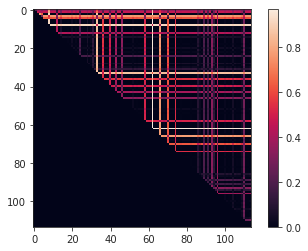

In [281]:
plt.imshow(div[0])
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f3ee0343fa0>

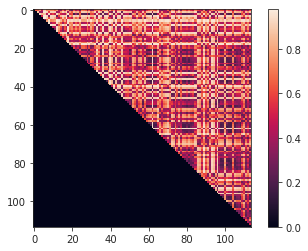

In [282]:
plt.imshow(div[10])
plt.colorbar()

In [285]:
dlist = []

for th_i, th in enumerate(fixed_thresholds):
    across = {
        (i, j): div[th_i][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[th_i][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = {k: v.mean() for k, v in across.items()}
    dlist.append({
        'threshold': [th] * len(data),
        'condition': ['across'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
    
    data = {k: v.mean() for k, v in within.items()}
    dlist.append({
        'threshold': [th] * len(data),
        'condition': ['within'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
df = pd.DataFrame(merge_dicts(dlist))

In [286]:
df

,threshold,condition,sessions,value
0,0.98,across,"(1, 2)",0.221823
1,0.98,across,"(1, 3)",0.165035
2,0.98,across,"(2, 3)",0.148672
3,0.98,within,1,0.238021
4,0.98,within,2,0.212988
...,...,...,...,...
349,0.40,across,"(1, 3)",0.763277
350,0.40,across,"(2, 3)",0.761124
351,0.40,within,1,0.778284
352,0.40,within,2,0.758154


In [288]:
df_avg = df.groupby(['threshold']).mean()
best_d = df_avg.index[df_avg.values.argmin()]
min_div = df_avg.values[df_avg.values.argmin()].item()

df_avg.iloc[[df_avg.values.argmin()]]

,value
threshold,
0.98,0.177766


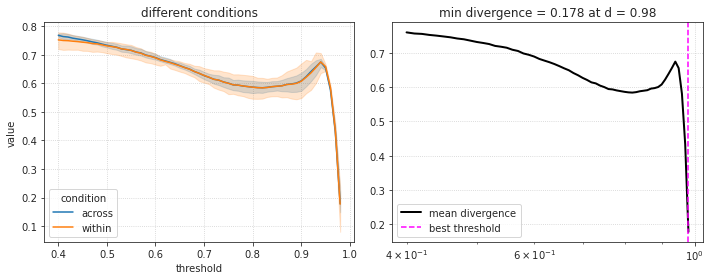

In [289]:
fig, axes = create_figure(1, 2, (10, 4))
sns.lineplot(data=df, x='threshold', y='value', hue='condition', ax=axes[0])
axes[0].set_title("different conditions")
axes[0].grid()

axes[1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.2f}")
axes[1].axvline(best_d, color='magenta', ls='--', label='best threshold')
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid()

plt.show()

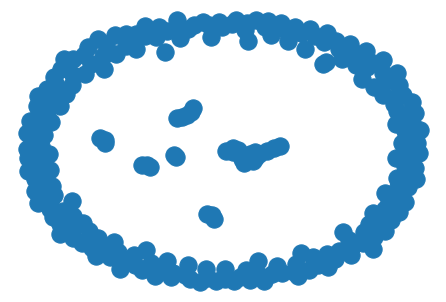

In [295]:
nx.draw(graphs[0][0.98])

<matplotlib.image.AxesImage object at 0x7f3ec475b580>

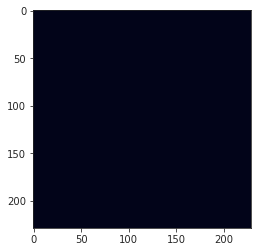

In [308]:
plt.imshow(nx.adj_matrix(graphs[10][0.98]).todense())

### On real graphs

In [9]:
mice = Mice((192, 4))
mice.setup_func_data('rest')

In [10]:
adjacencies = collections.defaultdict(list)
for key in mice.ca:
    sub, ses, run = mice.looper[key]
    if run == -1:
        continue
    net = Network(mice, key, 'ca2').load_network()
    adjacencies[ses].append(np.expand_dims(net.adj, 0))

adjacencies = {
    k: np.concatenate(v) for
    k, v in adjacencies.items()
}

n_runs = 0
ses_ids = {}
for ses, a in adjacencies.items():
    ses_ids[ses] = range(n_runs, n_runs + len(a))
    n_runs += len(a)
    
adjacencies = np.concatenate(list(adjacencies.values()))
assert len(adjacencies) == n_runs

n_runs, ses_ids, adjacencies.shape

(114, {1: range(0, 39), 2: range(39, 78), 3: range(78, 114)}, (114, 300, 300))

In [101]:
start = 0.50
stop = 0.01
spacing = 0.01
num = int(np.ceil((start - stop) / spacing)) + 1
densities = np.linspace(start, stop, num)
densities = np.round(densities, 4)
densities

array([0.5 , 0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4 ,
       0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.32, 0.31, 0.3 , 0.29,
       0.28, 0.27, 0.26, 0.25, 0.24, 0.23, 0.22, 0.21, 0.2 , 0.19, 0.18,
       0.17, 0.16, 0.15, 0.14, 0.13, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.07,
       0.06, 0.05, 0.04, 0.03, 0.02, 0.01])

In [102]:
%%time

graphs = collections.defaultdict(dict)
portraits = collections.defaultdict(dict)
thresholds = np.zeros((n_runs, len(densities)))

for ses, ids in ses_ids.items():
    for i in tqdm(ids, leave=False):
        a = adjacencies[i]
        thres = calculate_threshold(a, densities)
        thresholds[i] = thres
        
        nonzero = np.abs(a).mean(0) > 0
        for d, th in zip(densities, thres):
            a_eff = a[nonzero][:, nonzero]
            a_eff[a_eff <= th] = 0.
            g = nx.from_numpy_matrix(a_eff)
            graphs[i][np.round(d, 4)] = g
            portraits[i][np.round(d, 4)] = portrait_py(g)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 21min 38s, sys: 11.6 s, total: 21min 49s
Wall time: 21min 49s


<matplotlib.image.AxesImage object at 0x7f41f51870a0>

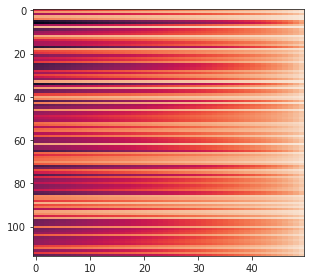

In [109]:
fig, ax = create_figure()
ax.imshow(thresholds, aspect=0.4)

<matplotlib.image.AxesImage object at 0x7f41f500feb0>

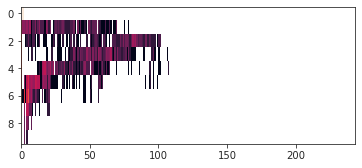

In [112]:
plt.imshow(np.log(portraits[16][0.1]), aspect=10)

<matplotlib.image.AxesImage object at 0x7f41f4fb4f40>

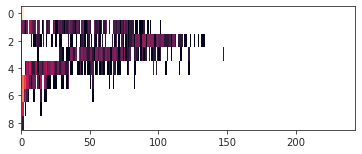

In [114]:
plt.imshow(np.log(portraits[16][0.15]), aspect=10)

In [115]:
div = {
    np.round(d, 4): np_nans((n_runs, n_runs))
    for d in densities
}
{k: v.shape for k, v in div.items()}

{
    0.5: (114, 114),
    0.49: (114, 114),
    0.48: (114, 114),
    0.47: (114, 114),
    0.46: (114, 114),
    0.45: (114, 114),
    0.44: (114, 114),
    0.43: (114, 114),
    0.42: (114, 114),
    0.41: (114, 114),
    0.4: (114, 114),
    0.39: (114, 114),
    0.38: (114, 114),
    0.37: (114, 114),
    0.36: (114, 114),
    0.35: (114, 114),
    0.34: (114, 114),
    0.33: (114, 114),
    0.32: (114, 114),
    0.31: (114, 114),
    0.3: (114, 114),
    0.29: (114, 114),
    0.28: (114, 114),
    0.27: (114, 114),
    0.26: (114, 114),
    0.25: (114, 114),
    0.24: (114, 114),
    0.23: (114, 114),
    0.22: (114, 114),
    0.21: (114, 114),
    0.2: (114, 114),
    0.19: (114, 114),
    0.18: (114, 114),
    0.17: (114, 114),
    0.16: (114, 114),
    0.15: (114, 114),
    0.14: (114, 114),
    0.13: (114, 114),
    0.12: (114, 114),
    0.11: (114, 114),
    0.1: (114, 114),
    0.09: (114, 114),
    0.08: (114, 114),
    0.07: (114, 114),
    0.06: (114, 114),
    0.05: (114, 114),
    0.04: (114, 114),
    0.03: (114, 114),
    0.02: (114, 114),
    0.01: (114, 114)
}

In [116]:
for d in tqdm(densities):
    for i, j in tqdm(itertools.combinations(range(n_runs), 2), leave=False):
        div[d][i, j] = portrait_divergence(portraits[i][d], portraits[j][d])

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

<matplotlib.image.AxesImage object at 0x7f41f4ce3400>

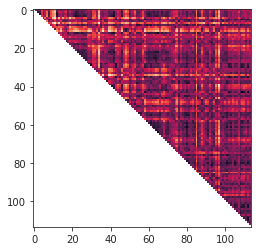

In [117]:
plt.imshow(div[0.1])

<matplotlib.image.AxesImage object at 0x7f41f4caad90>

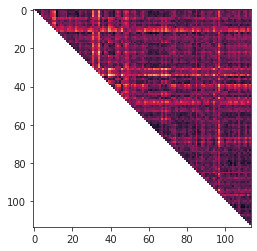

In [118]:
plt.imshow(div[0.3])

In [119]:
dlist = []
for d, mat in div.items():
    across = {
        (i, j): mat[ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: mat[ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = {k: v.mean() for k, v in across.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
    
    data = {k: v.mean() for k, v in within.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
df = pd.DataFrame(merge_dicts(dlist))

In [120]:
df

,density,condition,sessions,value
0,0.50,across,"(1, 2)",0.348677
1,0.50,across,"(1, 3)",0.342971
2,0.50,across,"(2, 3)",0.337317
3,0.50,within,1,0.353829
4,0.50,within,2,0.344975
...,...,...,...,...
295,0.01,across,"(1, 3)",0.392772
296,0.01,across,"(2, 3)",0.359362
297,0.01,within,1,0.435116
298,0.01,within,2,0.381484


In [151]:
df_avg = df.groupby(['density']).mean()
best_d = df_avg.index[df_avg.values.argmin()]
min_div = df_avg.values[df_avg.values.argmin()].item()

df_avg.iloc[[df_avg.values.argmin()]]

,value
density,
0.08,0.311046


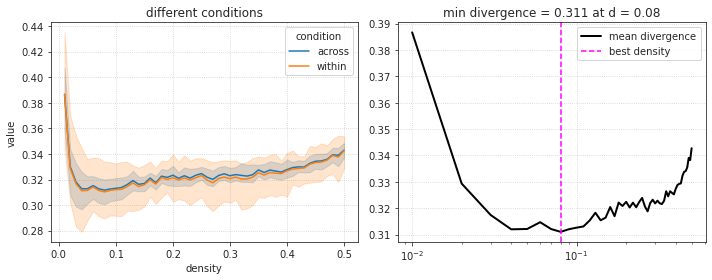

In [164]:
fig, axes = create_figure(1, 2, (10, 4))
sns.lineplot(data=df, x='density', y='value', hue='condition', ax=axes[0])
axes[0].set_title("different conditions")
axes[0].grid()

axes[1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.2f}")
axes[1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid()

plt.show()